In [118]:
import pandas as pd

In [119]:
import random
import numpy as np

# set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [120]:
# Target id
target_id = "CHEMBL262"

In [121]:
from loader.load_chembl import parse_activities
# Load the data
target_raw = parse_activities(target_id=target_id)

In [122]:
target_raw.shape

(4587, 46)

In [123]:
from loader.clean_chembl import clean_data
# Clean the data
target_clean = clean_data(target_id=target_id, rewrite=False)

In [124]:
target_clean.shape

(3634, 2)

In [125]:
import numpy as np

y10 = target_clean['standard_value'] * 1e-9 # to moles
y10 = -np.log10(y10)
y10.dropna(inplace=True)

D:\python_projects\alzheimer-generative-design\venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [128]:
y10

molecule_chembl_id
CHEMBL388978     7.522879
CHEMBL102714     7.703335
CHEMBL259850     6.309804
CHEMBL50894      8.187087
CHEMBL3545157    6.856985
                   ...   
CHEMBL1834109    5.920819
CHEMBL1834110    6.221849
CHEMBL1834111    6.180456
CHEMBL1834112    5.677781
CHEMBL189963     5.000000
Name: standard_value, Length: 3630, dtype: float64

In [129]:
ids = y10.index

In [130]:
from predictor.descriptor_computer import get_desc_dataset

rdkit_desc = get_desc_dataset(target_id, "rdkit")
rdkit_desc.shape

(3634, 219)

In [131]:
from predictor.processing import remove_collinear_features

x_rdkit_desc = rdkit_desc.drop(columns=["smiles", "standard_value"])
x_rdkit_desc = x_rdkit_desc.loc[ids, :]
x_rdkit_desc.dropna(axis=1, how="any", inplace=True)
x_rdkit_desc = x_rdkit_desc.select_dtypes(include=['number'])
x_rdkit_desc = x_rdkit_desc.loc[:, x_rdkit_desc.std() != 0]
x_rdkit_filtered = remove_collinear_features(x_rdkit_desc, threshold=0.7)

In [132]:
from predictor.descriptor_computer import get_desc_dataset

mordred_desc = get_desc_dataset(target_id, "mordred")
mordred_desc.shape

D:\python_projects\alzheimer-generative-design\predictor\descriptor_computer.py:44: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,56,57,58,59,60,61,62,63,64,138,139,140,141,142,143,144,145,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,165,166,167,168,169,170,171,172,174,175,176,177,178,179,180,181,183,184,185,186,187,188,189,190,192,193,194,195,196,197,198,199,201,202,203,204,205,206,207,208,210,211,212,213,214,215,216,217,219,220,221,222,223,224,225,226,228,229,230,231,232,233,234,235,263,264,265,266,267,268,269,270,271,345,346,347,348,349,350,351,352,354,355,356,357,358,359,360,361,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,381,382,383,384,385,386,387,388,390,391,392,393,394,395,396,397,399,400,401,402,403,404,405,406,408,409,410,411,412,413,414,415,417,418,419,420,421,422,423,424,426,427,428,429,430,431,432,433,435,436,437,438,439,440,441,442,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,4

(3634, 1828)

In [133]:
x_mordred_desc = mordred_desc.drop(columns=["smiles", "standard_value"])
x_mordred_desc = x_mordred_desc.loc[ids, :]
x_mordred_desc.dropna(axis=1, how="any", inplace=True)
x_mordred_desc = x_mordred_desc.select_dtypes(include=['number'])
x_mordred_desc = x_mordred_desc.loc[:, x_mordred_desc.std() != 0]
x_mordred_filtered = remove_collinear_features(x_mordred_desc, threshold=0.8)

In [140]:
from predictor.fingerprint_computer import get_fp_dataset
from rdkit.Chem import rdFingerprintGenerator

radius=3
fp_size=1024
fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fp_size)
morgan_fp = get_fp_dataset(target_id, f"morgan_{radius}_{fp_size}", fp_gen)
morgan_fp.shape

(3634, 1026)

In [141]:
x_morgan_fp = morgan_fp.drop(columns=["smiles", "standard_value"])
x_morgan_fp = x_morgan_fp.loc[ids, :]
x_morgan_fp.shape

(3630, 1024)

In [142]:
from sklearn.model_selection import KFold

n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']
results_path = 'results.csv'

In [143]:
x_rdkit_morgan = pd.concat([x_rdkit_filtered, x_morgan_fp], axis=1)

In [138]:
x_rdkit_morgan_filtered = remove_collinear_features(x_rdkit_morgan, threshold=0.8)

In [86]:
x_rdkit_morgan_filtered.shape

(3630, 1137)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


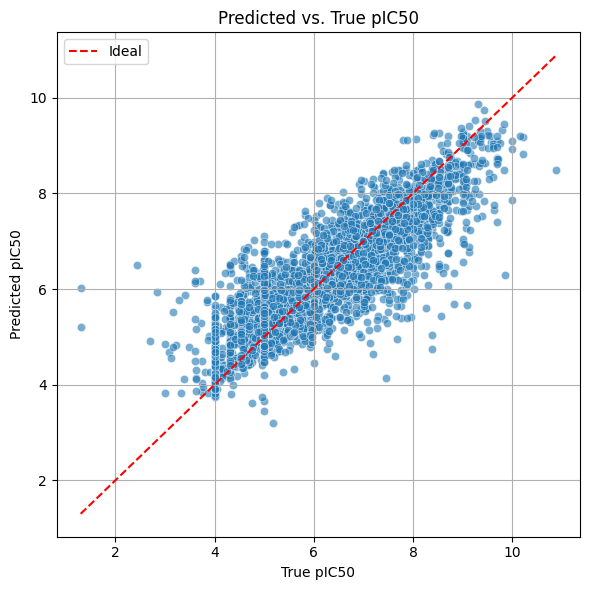

Cross-validation mean scores:
  r2, mean: 0.7236, std: 0.0202
  neg_mean_absolute_error, mean: -0.5233, std: 0.0207
  neg_root_mean_squared_error, mean: -0.7234, std: 0.0360
Appended new experiment to results.csv


In [146]:
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, SGDRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, RobustScaler
from predictor.pipeline import run_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
# import xgboost
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# import xgboost
# import catboost
# import light

# baseline: RFRegressor
estimator, pipeline = run_pipeline(
    X=x_rdkit_morgan,
    y=y10.squeeze(),
    cv=cv,
    model=CatBoostRegressor(
        iterations=1500,
        learning_rate=0.03,
        depth=8,
        l2_leaf_reg=3,
        bagging_temperature=1.0,
        random_strength=1.0,
        grow_policy="Lossguide",
        min_data_in_leaf=5,
        border_count=128,
        early_stopping_rounds=50,
    ),
    # scaler=RobustScaler(),
    # selector=SelectKBest(f_regression, k=1000),
    # dim_reducer=PCA(n_components=100),
    scoring=scoring,
    results_path=results_path,
)

In [21]:
pd.DataFrame(pipeline['model'].feature_importances_, index=x_rdkit_morgan_filtered.columns).sort_values(by=0, ascending=False)

ValueError: Must pass 2-d input. shape=()

In [147]:
pipeline.fit(X=x_rdkit_morgan,
    y=y10.squeeze())

0:	learn: 1.3628375	total: 54.6ms	remaining: 1m 21s
1:	learn: 1.3477368	total: 172ms	remaining: 2m 8s
2:	learn: 1.3330293	total: 359ms	remaining: 2m 59s
3:	learn: 1.3190927	total: 431ms	remaining: 2m 41s
4:	learn: 1.3048499	total: 485ms	remaining: 2m 24s
5:	learn: 1.2933210	total: 549ms	remaining: 2m 16s
6:	learn: 1.2811522	total: 626ms	remaining: 2m 13s
7:	learn: 1.2675792	total: 702ms	remaining: 2m 10s
8:	learn: 1.2549413	total: 747ms	remaining: 2m 3s
9:	learn: 1.2438219	total: 802ms	remaining: 1m 59s
10:	learn: 1.2308952	total: 846ms	remaining: 1m 54s
11:	learn: 1.2201679	total: 911ms	remaining: 1m 52s
12:	learn: 1.2088509	total: 985ms	remaining: 1m 52s
13:	learn: 1.1976782	total: 1.05s	remaining: 1m 51s
14:	learn: 1.1877272	total: 1.11s	remaining: 1m 49s
15:	learn: 1.1776313	total: 1.16s	remaining: 1m 47s
16:	learn: 1.1676964	total: 1.22s	remaining: 1m 46s
17:	learn: 1.1577478	total: 1.27s	remaining: 1m 44s
18:	learn: 1.1475855	total: 1.34s	remaining: 1m 44s
19:	learn: 1.1385676	to

Pipeline(steps=[('model',
                 <catboost.core.CatBoostRegressor object at 0x00000221FC0DEE00>)])

In [148]:
import joblib

joblib.dump(pipeline, 'catboost_rdkit_morgan.pkl')

['catboost_rdkit_morgan.pkl']

In [25]:

pipeline['model'].feature_names_in_

AttributeError: 'CatBoostRegressor' object has no attribute 'feature_names_in_'

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from predictor.pipeline import get_preprocessing_pipeline
from scipy.stats import uniform, randint

def tune_model_params(X, y, cv, selector=None, scaler=None, dim_reducer=None, n_iter=30):
    preprocessing = get_preprocessing_pipeline(
        selector=selector,
        scaler=scaler,
        dim_reducer=dim_reducer
    )

    full_pipeline = Pipeline([
        ('preprocessing', preprocessing),
        ('model', CatBoostRegressor(
            verbose=0,
            random_state=42,
            early_stopping_rounds=50  # <-- stop early if no improvement in 50 rounds
        ))
    ])

    param_distributions = {
        'model__depth': randint(4, 8),
        'model__learning_rate': uniform(0.01, 0.09),
        'model__l2_leaf_reg': randint(1, 11),
        'model__iterations': [100, 250, 500],  # fixed choices instead of range
        'model__bagging_temperature': uniform(0, 5),
        'model__border_count': randint(32, 129),
        'model__random_strength': uniform(0.5, 2.0),
        'model__grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
    }

    search = RandomizedSearchCV(
        estimator=full_pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring='r2',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    search.fit(X, y)
    print("Лучшие параметры:", search.best_params_)
    print("R2 score (CV):", search.best_score_)

    return search.best_estimator_

In [67]:

from predictor.pipeline import get_preprocessing_pipeline
# 1. Подбор лучших параметров
best_model_pipeline = tune_model_params(
    X=x_rdkit_morgan_filtered,
    y=y10.squeeze(),
    cv=cv,
)

# 2. Извлеки готовую модель
best_model = best_model_pipeline.named_steps['model']

# # 3. Запусти эксперимент с лучшей моделью
# final_pipeline = run_pipeline(
#     X=x_rdkit_desc,
#     y=y10.squeeze(),
#     cv=cv,
#     model=best_model,
#     scaler=StandardScaler(),  # те же preprocessing шаги
#     scoring=scoring,
#     results_path=results_path
# )

Fitting 5 folds for each of 30 candidates, totalling 150 fits



KeyboardInterrupt



In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


X = x_rdkit_desc

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_embedded = tsne.fit_transform(X)

# Plot with continuous color scale
plt.figure(figsize=(10, 8))
sc = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y10, cmap='viridis', s=60)
plt.colorbar(sc, label='pIC50')
plt.title('t-SNE of Molecular Descriptors (Mordred)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()